In [2]:
# -------
# IMPORT LIBRAIRIES
# -------
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.linear_model import LinearRegression
from python_module.pricing_model import SABRModel
from python_module.tools import maximize_with_bounds

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
# -------
# INPUTS
# -------

# Pricing parameters
F     = 100
alpha = 0.25
beta  = 1.0
rho   = -0.5
nu    = 1.5
r     = 0
bd    = 5

# Scenario parameters
scenario_min = -0.3
scenario_max = 0.3
scenario_step = 0.01

In [4]:
# Generate list of slides to compute 
num = int((scenario_max-scenario_min)/0.01 + 1)
slide_to_compute = list(np.round(np.linspace(start=scenario_min, stop=scenario_max, num=num), 2))

In [6]:
# Generate Option portfolio
option_portfolio = list()

for K in range(1, 200, 1):
    
    T = bd / 250
    option_type = 'call' if K >= F else 'put'
    market_pricing_results = SABRModel.compute_option(
        F, K, T, alpha, beta, rho, nu, r, option_type, slide_list=slide_to_compute, slide_type='spot_vol', slide_compute='delta_hedged_pnl')

    option_portfolio.append({
        'symbol': f"{bd}T_{K}K_{option_type}",
        'option_type': option_type, 
        'bd': bd, 
        'F':F, 'r': r, 'K': K, 'T': T, 'K/F': (K/F) - 1 ,**market_pricing_results})
    
option_portfolio_df = pd.DataFrame(option_portfolio)
option_portfolio_df = option_portfolio_df.set_index('symbol')

In [56]:
portfolio_slide_df = option_portfolio_df.loc[:, option_portfolio_df.columns[16:]].transpose().sort_index()
portfolio_slide_target = pd.Series(index=portfolio_slide_df.index)
portfolio_slide_target = option_portfolio_df[option_portfolio_df['K']==F].iloc[0][option_portfolio_df.columns[16:]].sort_index()
portfolio_slide_target.loc[:-0.02] = 0
portfolio_slide_target.loc[0.02:] = 0

In [58]:
model = LinearRegression(fit_intercept=False, positive=False)
model.fit(portfolio_slide_df, portfolio_slide_target)
portfolio_slide_built = portfolio_slide_df.dot(model.coef_)
weights = pd.Series(index=portfolio_slide_df.columns, data=model.coef_)
portfolio_theta = option_portfolio_df['theta'].multiply(weights).sum()
portfolio_gamma_cash = option_portfolio_df['gamma_cash'].multiply(weights).sum()
portoflio_be = np.sqrt(-portfolio_theta/(50*portfolio_gamma_cash)) * np.sqrt(250)

In [60]:
portfolio_theta

-0.021091371774673462

In [62]:
option_portfolio_df[option_portfolio_df['K']==F].iloc[0]['theta']

-0.14122361375923093

In [64]:
portoflio_be

0.19427658474438847

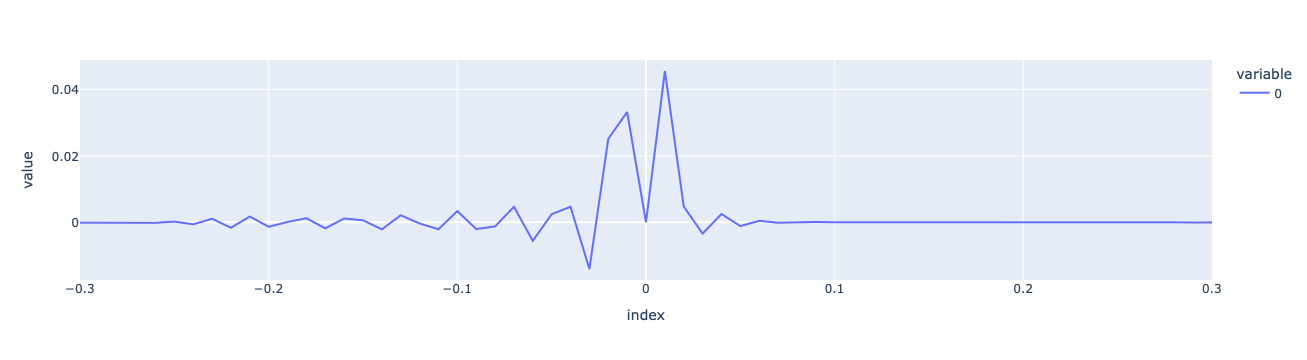

In [66]:
px.line(portfolio_slide_built)

In [ ]:
px.line(portfolio_slide_built)

In [ ]:
import numpy as np
from scipy.optimize import lsq_linear
from sklearn.metrics import mean_squared_error, r2_score

# Prepare data
X = df.values        # shape (n_samples, n_features)
y = s.values         # shape (n_samples,)

# Define bounds: lower = 0, upper = max_coef for every coefficient
max_coef = 1.5       # set your desired maximum
lb = np.zeros(X.shape[1])
ub = np.full(X.shape[1], max_coef)

# Solve min ||Xw - y||² s.t. lb ≤ w ≤ ub
res = lsq_linear(X, y, bounds=(lb, ub), lsmr_tol='auto', verbose=1)

w_bounded = res.x
print("Bounded weights:", w_bounded)

# Predictions & metrics
y_pred = X.dot(w_bounded)
print(f"MSE: {mean_squared_error(y, y_pred):.4f}")
print(f"R² : {r2_score(y, y_pred):.4f}")
